In [1]:
import functools
import tensorflow as tf
from core.model import ModelMNIST10x10_base
from core.hessian import hessians_highrank

class Implement(ModelMNIST10x10_base):
    def __init__(self, batch_size=128, opt=tf.train.MomentumOptimizer(1.0, 0.0, use_nesterov=True)):
        self.batch_ratio = max(1.0, 1.0 * batch_size / 50000.0)
        super(Implement, self).__init__(batch_size, opt)

    def compute_gradient(self, cost, var_refs):
        grads = tf.gradients(
                cost, var_refs,
                grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
        hessis = hessians_highrank(
                 cost, var_refs, gradients=grads,
                 aggregation_method=None, colocate_gradients_with_ops=True)
        
        second_order_grads = []
        for l, g, h, v in zip(range(len(grads)), grads, hessis, var_refs):
            shape = g.shape
            d = int(functools.reduce(lambda a,b: a*b, shape))
            
            is_calculating_hessian = ('conv' in v.name)# and ('weight' in v.name)
            if is_calculating_hessian:
                g_dot = tf.reshape(g, [d, 1])
                h_dot = tf.reshape(h, [d, d])
                h_dot = h_dot + (tf.eye(d)+1e-2)
            
                h_inv = tf.matrix_inverse(h_dot)
                h_inv_clipped = tf.clip_by_value(h_inv , -1.0, +1.0 )
                delta = tf.matmul(h_inv_clipped, g_dot)
                delta = tf.reshape(delta, shape)
            else:
                delta = g

            second_order_grads.append(delta)

            tf.summary.histogram('{}'.format(v.name.replace(':', '_')), v)
            tf.summary.histogram('{}/gradient'.format(v.name.replace(':', '_')), g)
            tf.summary.histogram('{}/delta'.format(v.name.replace(':', '_')), delta)
            if is_calculating_hessian:
                tf.summary.histogram('{}/hessian/diag'.format(v.name.replace(':', '_')), h)
                tf.summary.histogram('{}/hessian/inv/diag'.format(v.name.replace(':', '_')), h_inv)
                tf.summary.histogram('{}/hessian/inv/clip/diag'.format(v.name.replace(':', '_')), h_inv_clipped)

        return second_order_grads

In [2]:
import sys
import logging
logging.basicConfig(level=logging.DEBUG, format='[%(levelname)s] %(message)s', stream=sys.stdout)

model = Implement(batch_size=128*100)

[1204 14:43:40 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[1204 14:43:41 @prefetch.py:169] [PrefetchData] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.


In [3]:
from core.utils import loop

%env CUDA_VISIBLE_DEVICES=1
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
sess = tf.Session(config=config)
history = loop(sess, model, 30, './summary/6_2_second_order_optimization_batch_128x100')

env: CUDA_VISIBLE_DEVICES=1
[INFO] session initialized
[DEBUG] [train] cost:0.874 accuracy:0.093 elapsed:25.213sec
[DEBUG] [train] cost:0.718 accuracy:0.079 elapsed:22.274sec
[DEBUG] [train] cost:0.399 accuracy:0.130 elapsed:22.242sec
[DEBUG] [train] cost:0.354 accuracy:0.184 elapsed:22.273sec
[DEBUG] [valid] cost:0.338 accuracy:0.187 elapsed:0.194sec
[INFO] [0000] [train] cost:0.586 accuracy:0.121 elapsed:92.002sec [valid] cost:0.338 accuracy:0.187 elapsed:0.194sec
[DEBUG] [train] cost:0.324 accuracy:0.249 elapsed:22.285sec
[DEBUG] [train] cost:0.306 accuracy:0.287 elapsed:22.294sec
[DEBUG] [train] cost:0.290 accuracy:0.346 elapsed:22.264sec
[DEBUG] [train] cost:0.279 accuracy:0.388 elapsed:22.252sec
[DEBUG] [valid] cost:0.277 accuracy:0.389 elapsed:0.010sec
[INFO] [0001] [train] cost:0.300 accuracy:0.318 elapsed:89.096sec [valid] cost:0.277 accuracy:0.389 elapsed:0.010sec
[DEBUG] [train] cost:0.269 accuracy:0.428 elapsed:22.265sec
[DEBUG] [train] cost:0.261 accuracy:0.458 elapsed:22.

[DEBUG] [valid] cost:0.135 accuracy:0.781 elapsed:0.012sec
[INFO] [0019] [train] cost:0.135 accuracy:0.788 elapsed:89.172sec [valid] cost:0.135 accuracy:0.781 elapsed:0.012sec
[DEBUG] [train] cost:0.132 accuracy:0.796 elapsed:22.311sec
[DEBUG] [train] cost:0.133 accuracy:0.797 elapsed:22.286sec
[DEBUG] [train] cost:0.133 accuracy:0.788 elapsed:22.295sec
[DEBUG] [train] cost:0.132 accuracy:0.791 elapsed:22.276sec
[DEBUG] [valid] cost:0.133 accuracy:0.785 elapsed:0.011sec
[INFO] [0020] [train] cost:0.132 accuracy:0.793 elapsed:89.168sec [valid] cost:0.133 accuracy:0.785 elapsed:0.011sec
[DEBUG] [train] cost:0.130 accuracy:0.798 elapsed:22.303sec
[DEBUG] [train] cost:0.129 accuracy:0.803 elapsed:22.306sec
[DEBUG] [train] cost:0.130 accuracy:0.799 elapsed:22.281sec
[DEBUG] [train] cost:0.129 accuracy:0.798 elapsed:22.290sec
[DEBUG] [valid] cost:0.130 accuracy:0.791 elapsed:0.011sec
[INFO] [0021] [train] cost:0.129 accuracy:0.800 elapsed:89.179sec [valid] cost:0.130 accuracy:0.791 elapsed:0

average elapsed time train:89.173690sec valid:0.010938sec


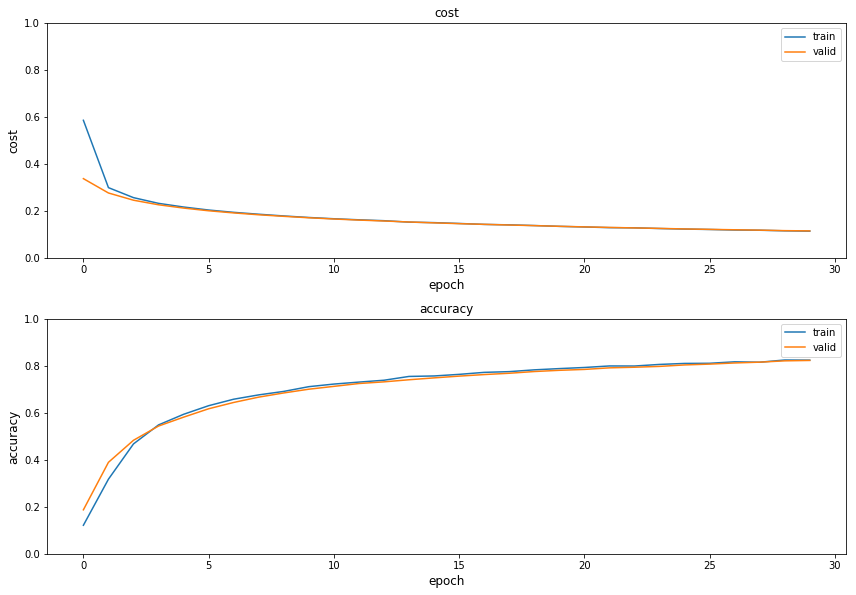

In [4]:
import matplotlib
%matplotlib inline

from core.utils import plot_jupyter
plot_jupyter(history)